In [2]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import creator, base, tools, algorithms

data = pd.read_excel('Project3_DistancesMatrix.xlsx', header=None) 

# Exclude first row and column, beacuse they are labels
### ATENTION: In the test, we will not receive like this
distances = data.values[1:, 1:]  

# 100 ecopoints, in this case
number_of_ecopoints = len(distances) - 1


def evalTSP(individual: list)-> tuple: 
    """
    Fitness of an individual. The fitness is the total distance of the route.

    Args:
        individual (list): Individual to evaluate

    Returns:
        tuple: Tuple with a float value of Fitness of the individual
    """    

    total_distance = sum(distances[individual[i-1] + 1][individual[i] + 1] for i in range(1, len(individual)))
    total_distance += distances[0][individual[0] + 1]
    total_distance += distances[individual[-1] + 1][0]
    
    # Return a tuple with a single value because it's a requisite of DEAP
    return (total_distance,)  


# -----------------------------------------------------------------------------------------------------------------------------------

# FitnessMin is a class inherited from base.Fitness and it has weights and values attributes
# Individual is a list of integers (ecopoints)
# weights = (-1.0,) because we want to minimize the total distance, (1.0) if we want to maximize
# Toolbox is a container for the tools that will be used to manipulate the individuals

# Register genetic operators
# mate: cxOrdered - order crossover
# mutate: mutShuffleIndexes - shuffle mutation
# select: selTournament - tournament selection


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
"""
#toolbox.register("indices", nearest_neighbor_tour, distances)
toolbox.register("indices", np.random.permutation, len(distances))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.00)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalTSP)

"""

toolbox.register("indices", np.random.permutation, range(number_of_ecopoints)) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
# mate: cxOrdered - order crossover
# mutate: mutShuffleIndexes - shuffle mutation
# select: selTournament - tournament selection

toolbox.register("mate", tools.cxOrdered) # cxOrdered - order crossover CANNOT BE USED
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
#toolbox.register("mutate", customMutShuffleIndexes, indpb=0.10)
#toolbox.register("mate", customCxOrdered)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalTSP)



# -----------------------------------------------------------------------------------------------------------------------------------

n_populations = 10 * 1000 * 10
n_generations = 10 * n_populations 
prob_mutation = 0.01 # 0.01, 0.05, 0.1, 0.2
prob_crossover = 0.8 # 0.5, 0.6, 0.7, 0.8
convergence_generations = n_generations//10 * 4   # Number of generations over which to check for convergence
convergence_threshold = 0.0001  # The relative change in best fitness that signifies convergence

# Population
pop = toolbox.population(n=n_populations)

# Hall of fame of 1 best individual
hof = tools.HallOfFame(1)

# Lists to store the fitness evolution
best_fitness_evolution = []
avg_fitness_evolution = []
min_fitness_evolution = []
max_fitness_evolution = []

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

print("Start of evolution")

start_time = time.time()
timeout = 480 * 60  # minutes x seconds || 8h

# Run the evolution
gen = 0
converged = False
while time.time() - start_time < timeout and gen < n_generations and not converged:
    gen += 1
    # Select and clone the next generation individuals
    offspring = map(toolbox.clone, toolbox.select(pop, len(pop)))
    
    # Apply crossover and mutation on the offspring
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=prob_crossover, mutpb=prob_mutation)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Replace the current population by the offspring
    pop[:] = offspring

    # Update the hall of fame with the generated individuals
    hof.update(pop)

    # Record the stats of the current generation
    record = stats.compile(pop)
    print(f"Generation {gen}: {record}")

    # Record the best, avg, min and max fitness from this generation to the lists
    best_fitness_evolution.append(hof[0].fitness.values[0])
    avg_fitness_evolution.append(record["avg"])
    min_fitness_evolution.append(record["min"])
    max_fitness_evolution.append(record["max"])

    # Check for convergence: if the best fitness has not improved significantly for a certain number of generations
    if gen >= convergence_generations:
        relative_change = (best_fitness_evolution[-convergence_generations] - best_fitness_evolution[-1]) / best_fitness_evolution[-convergence_generations]
        if abs(relative_change) < convergence_threshold:
            print("Convergence reached")
            converged = True

# Best individual
print(f"Best individual is: {hof[0]}, {len(hof[0])} \nwith fitness: {hof[0].fitness}")

c:\Users\leo_b\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\leo_b\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Start of evolution
Generation 1: {'avg': 335.55282700000004, 'min': 252.79999999999998, 'max': 401.89999999999986}
Generation 2: {'avg': 323.080278, 'min': 252.00000000000009, 'max': 392.99999999999983}
Generation 3: {'avg': 313.903353, 'min': 247.1999999999999, 'max': 380.8000000000001}
Generation 4: {'avg': 306.3529419999999, 'min': 235.7999999999998, 'max': 375.5999999999999}
Generation 5: {'avg': 299.91371200000003, 'min': 235.7999999999998, 'max': 368.40000000000015}
Generation 6: {'avg': 294.132684, 'min': 223.29999999999987, 'max': 371.3999999999999}
Generation 7: {'avg': 288.842147, 'min': 215.4999999999999, 'max': 357.90000000000003}
Generation 8: {'avg': 284.06935699999997, 'min': 215.4999999999999, 'max': 363.0}
Generation 9: {'avg': 279.711746, 'min': 221.59999999999994, 'max': 356.29999999999984}
Generation 10: {'avg': 275.63659, 'min': 218.50000000000003, 'max': 361.1999999999998}
Generation 11: {'avg': 271.92913599999997, 'min': 209.59999999999997, 'max': 346.9}
Generati

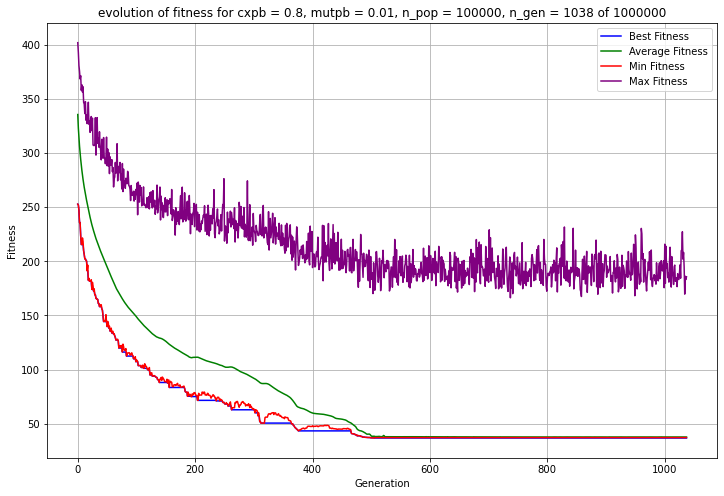

In [4]:
# Plot the evolution of the fitness
def plot_evolution(which_stats,cxpb, mutpb, n_pop, n_gen):
    plt.figure(figsize=(12, 8))
    if "fitness" in which_stats:
        plt.plot(best_fitness_evolution, label='Best Fitness', color='blue')
    if "avg" in which_stats:
        plt.plot(avg_fitness_evolution, label='Average Fitness', color='green')
    if "min" in which_stats:
        plt.plot(min_fitness_evolution, label='Min Fitness', color='red')
    if "max" in which_stats:
        plt.plot(max_fitness_evolution, label='Max Fitness', color='purple')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"evolution of fitness for cxpb = {cxpb}, mutpb = {mutpb}, n_pop = {n_pop}, n_gen = {n_gen} of {n_generations}")
    plt.legend()
    plt.grid(True)
    plt.show()

# P

plot_evolution(["fitness", "avg", "min", "max"], prob_crossover, prob_mutation, n_populations, gen)

